# Customer Segmentation using Clustering
***
This mini-project is based on [this blog post](http://blog.yhat.com/posts/customer-segmentation-using-python.html) by yhat. Please feel free to refer to the post for additional information, and solutions.

In [82]:
%matplotlib inline
import pandas as pd
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Setup Seaborn
sns.set_style("whitegrid")
sns.set_context("poster")

## Data

The dataset contains information on marketing newsletters/e-mail campaigns (e-mail offers sent to customers) and transaction level data from customers. The transactional data shows which offer customers responded to, and what the customer ended up buying. The data is presented as an Excel workbook containing two worksheets. Each worksheet contains a different dataset.

In [8]:
df_offers = pd.read_excel("./WineKMC.xlsx", sheetname=0)
df_offers.columns = ["offer_id", "campaign", "varietal", "min_qty", "discount", "origin", "past_peak"]
df_offers.head()

,offer_id,campaign,varietal,min_qty,discount,origin,past_peak
0,1,January,Malbec,72,56,France,False
1,2,January,Pinot Noir,72,17,France,False
2,3,February,Espumante,144,32,Oregon,True
3,4,February,Champagne,72,48,France,True
4,5,February,Cabernet Sauvignon,144,44,New Zealand,True


We see that the first dataset contains information about each offer such as the month it is in effect and several attributes about the wine that the offer refers to: the variety, minimum quantity, discount, country of origin and whether or not it is past peak. The second dataset in the second worksheet contains transactional data -- which offer each customer responded to.

In [3]:
df_transactions = pd.read_excel("./WineKMC.xlsx", sheetname=1)
df_transactions.columns = ["customer_name", "offer_id"]
df_transactions['n'] = 1
df_transactions.head()

,customer_name,offer_id,n
0,Smith,2,1
1,Smith,24,1
2,Johnson,17,1
3,Johnson,24,1
4,Johnson,26,1


## Data wrangling

We're trying to learn more about how our customers behave, so we can use their behavior (whether or not they purchased something based on an offer) as a way to group similar minded customers together. We can then study those groups to look for patterns and trends which can help us formulate future offers.

The first thing we need is a way to compare customers. To do this, we're going to create a matrix that contains each customer and a 0/1 indicator for whether or not they responded to a given offer. 

<div class="span5 alert alert-info">
<h3>Checkup Exercise Set I</h3>

<p><b>Exercise:</b> Create a data frame where each row has the following columns (Use the pandas [`merge`](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.merge.html) and [`pivot_table`](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.pivot_table.html) functions for this purpose):
<ul>
<li> customer_name
<li> One column for each offer, with a 1 if the customer responded to the offer
</ul>
<p>Make sure you also deal with any weird values such as `NaN`. Read the documentation to develop your solution.</p>
</div>

In [147]:
#Merging the dataframes
df_merged = df_offers.merge(df_transactions, how='left', on='offer_id')
df_merged.head()

,offer_id,campaign,varietal,min_qty,discount,origin,past_peak,customer_name,n
0,1,January,Malbec,72,56,France,False,Thomas,1
1,1,January,Malbec,72,56,France,False,Jackson,1
2,1,January,Malbec,72,56,France,False,Mitchell,1
3,1,January,Malbec,72,56,France,False,Peterson,1
4,1,January,Malbec,72,56,France,False,Wood,1


In [20]:
#Creating a pivot table
pivot_table = df_merged.pivot_table(index=['customer_name'], columns=['offer_id'], values='n', fill_value=0)
pivot_table.reset_index().head()

offer_id,customer_name,1,2,3,4,5,6,7,8,9,...,23,24,25,26,27,28,29,30,31,32
0,Adams,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,1,0,0
1,Allen,0,0,0,0,0,0,0,0,1,...,0,0,0,0,1,0,0,0,0,0
2,Anderson,0,0,0,0,0,0,0,0,0,...,0,1,0,1,0,0,0,0,0,0
3,Bailey,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,1,0,0
4,Baker,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,1,0


## K-Means Clustering

Recall that in K-Means Clustering we want to *maximize* the distance between centroids and *minimize* the distance between data points and the respective centroid for the cluster they are in. True evaluation for unsupervised learning would require labeled data; however, we can use a variety of intuitive metrics to try to pick the number of clusters K. We will introduce two methods: the Elbow method, the Silhouette method and the gap statistic.

### Choosing K: The Elbow Sum-of-Squares Method

The first method looks at the sum-of-squares error in each cluster against $K$. We compute the distance from each data point to the center of the cluster (centroid) to which the data point was assigned. 

$$SS = \sum_k \sum_{x_i \in C_k} \sum_{x_j \in C_k} \left( x_i - x_j \right)^2 = \sum_k \sum_{x_i \in C_k} \left( x_i - \mu_k \right)^2$$

where $x_i$ is a point, $C_k$ represents cluster $k$ and $\mu_k$ is the centroid for cluster $k$. We can plot SS vs. $K$ and choose the *elbow point* in the plot as the best value for $K$. The elbow point is the point at which the plot starts descending much more slowly. 

<div class="span5 alert alert-info">
<h3>Checkup Exercise Set II</h3>

<p><b>Exercise:</b></p> 
<ul>
<li> What values of $SS$ do you believe represent better clusterings? Why?
<li> Create a numpy matrix `x_cols` with only the columns representing the offers (i.e. the 0/1 colums) 
<li> Write code that applies the [`KMeans`](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html) clustering method from scikit-learn to this matrix. 
<li> Construct a plot showing $SS$ for each $K$ and pick $K$ using this plot. For simplicity, test $2 \le K \le 10$.
<li> Make a bar chart showing the number of points in each cluster for k-means under the best $K$.
<li> What challenges did you experience using the Elbow method to pick $K$?
</ul>
</div>

#### What values of  SS  do you believe represent better clusterings? Why?

The sum of squares is a measure of the variability within the cluster, so a smaller number would represent a more compact cluster, and a large number would represent a greater variability within the cluster. The optimal value of the sum of squares depends on the data and the task, but in general a more compact cluster (i.e. smaller values of SS) could mean better defined clusters.

In [27]:
#Creating a x_cols matrix
x_cols = pivot_table.iloc[:, 0:]
x_cols.head()

offer_id,1,2,3,4,5,6,7,8,9,10,...,23,24,25,26,27,28,29,30,31,32
customer_name,,,,,,,,,,,,,,,,,,,,,
Adams,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,1,0,0
Allen,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,1,0,0,0,0,0
Anderson,0,0,0,0,0,0,0,0,0,0,...,0,1,0,1,0,0,0,0,0,0
Bailey,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0
Baker,0,0,0,0,0,0,1,0,0,1,...,0,0,0,0,0,0,0,0,1,0


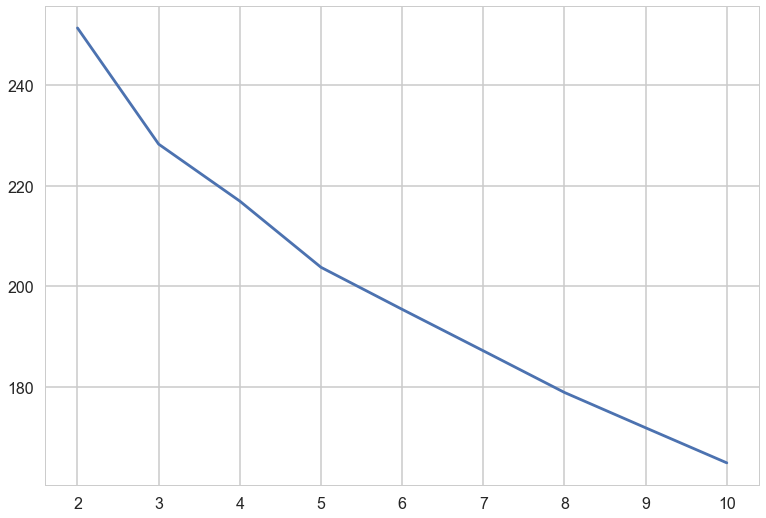

In [70]:
from sklearn.cluster import KMeans
k=[2,3,4,5,6,7,8,9,10]

#Calculcating sum of squares for different k
ss_by_k = {}
for k in k:
    model = KMeans(n_clusters=k, random_state=42)
    ss_by_k[k] = model.fit(x_cols).inertia_

#Sorting the dictionary and extracting x and y
k_list = sorted(ss_by_k.items())
x, y = zip(*k_list)

#Plotting the graph
plt.plot(x, y)
plt.show()

There's no clear 'elbow' on the graph, but the descent of the line slows down somewhat at k=3, which can be chosen as an approximate elbow in this case. In general, this case shows that the Elbow method may not always be very helpful to find the optimal k.

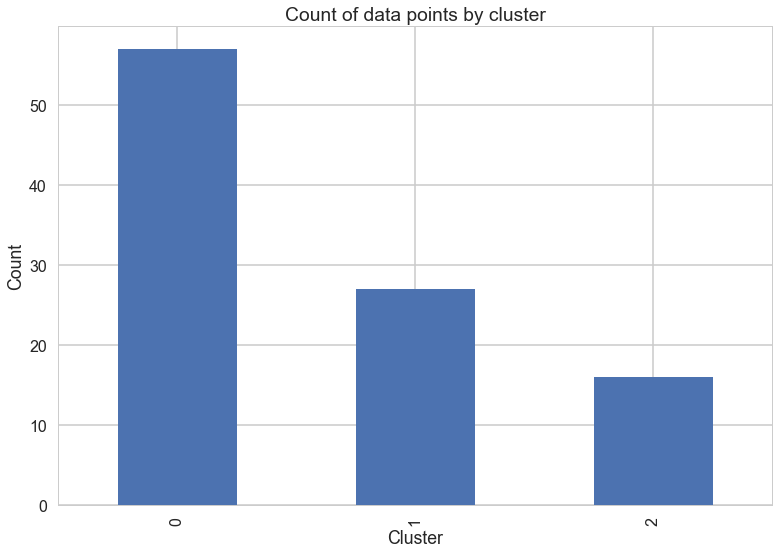

In [80]:
#Predicting clusters for k=3
prediction = KMeans(n_clusters=3, random_state=42).fit_predict(x_cols)

#Counting the number of data points in each cluster
clusters = pd.Series(prediction).value_counts()

_ = clusters.plot(kind='bar')
_ = plt.ylabel('Count')
_ = plt.xlabel('Cluster')
_ = plt.title('Count of data points by cluster')

### Choosing K: The Silhouette Method

There exists another method that measures how well each datapoint $x_i$ "fits" its assigned cluster *and also* how poorly it fits into other clusters. This is a different way of looking at the same objective. Denote $a_{x_i}$ as the *average* distance from $x_i$ to all other points within its own cluster $k$. The lower the value, the better. On the other hand $b_{x_i}$ is the minimum average distance from $x_i$ to points in a different cluster, minimized over clusters. That is, compute separately for each cluster the average distance from $x_i$ to the points within that cluster, and then take the minimum. The silhouette $s(x_i)$ is defined as

$$s(x_i) = \frac{b_{x_i} - a_{x_i}}{\max{\left( a_{x_i}, b_{x_i}\right)}}$$

The silhouette score is computed on *every datapoint in every cluster*. The silhouette score ranges from -1 (a poor clustering) to +1 (a very dense clustering) with 0 denoting the situation where clusters overlap. Some criteria for the silhouette coefficient is provided in the table below.

<pre>

| Range       | Interpretation                                |
|-------------|-----------------------------------------------|
| 0.71 - 1.0  | A strong structure has been found.            |
| 0.51 - 0.7  | A reasonable structure has been found.        |
| 0.26 - 0.5  | The structure is weak and could be artificial.|
| < 0.25      | No substantial structure has been found.      |

</pre>
Source: http://www.stat.berkeley.edu/~spector/s133/Clus.html

Fortunately, scikit-learn provides a function to compute this for us (phew!) called [`sklearn.metrics.silhouette_score`](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.silhouette_score.html). Take a look at [this article](http://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html) on picking $K$ in scikit-learn, as it will help you in the next exercise set.

<div class="span5 alert alert-info">
<h3>Checkup Exercise Set III</h3>

<p><b>Exercise:</b> Using the documentation for the `silhouette_score` function above, construct a series of silhouette plots like the ones in the article linked above.</p>

<p><b>Exercise:</b> Compute the average silhouette score for each $K$ and plot it. What $K$ does the plot suggest we should choose? Does it differ from what we found using the Elbow method?</p>
</div>

**Exercise: Using the documentation for the silhouette_score function above, construct a series of silhouette plots like the ones in the article linked above.**

For n_clusters = 2 The average silhouette_score is : 0.0917487150875
For n_clusters = 3 The average silhouette_score is : 0.115424070379
For n_clusters = 4 The average silhouette_score is : 0.0967025836069
For n_clusters = 5 The average silhouette_score is : 0.145315688203
For n_clusters = 6 The average silhouette_score is : 0.133131266271
For n_clusters = 7 The average silhouette_score is : 0.130739507718
For n_clusters = 8 The average silhouette_score is : 0.123975729011
For n_clusters = 9 The average silhouette_score is : 0.120246511094


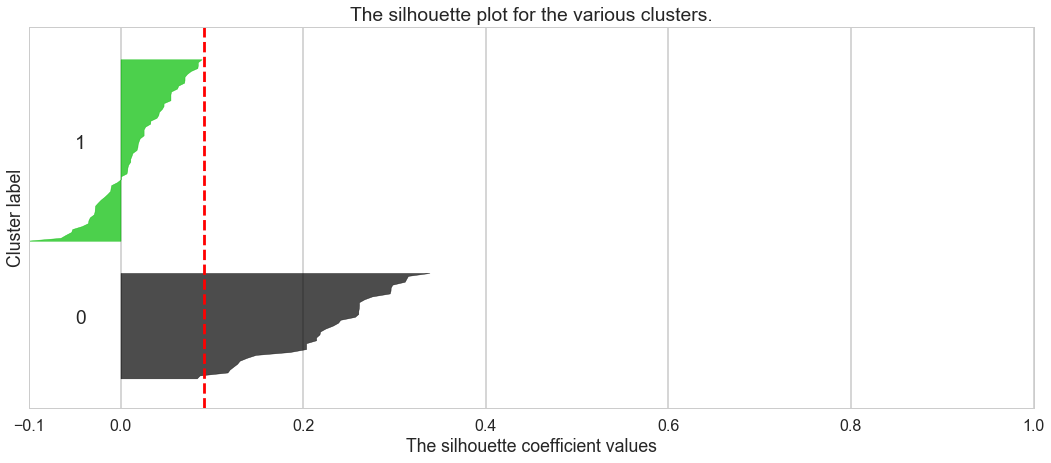

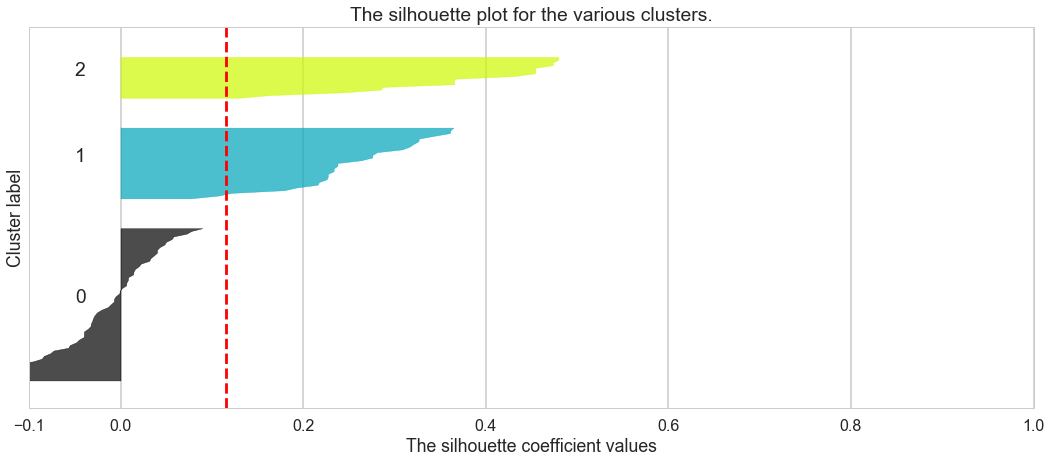

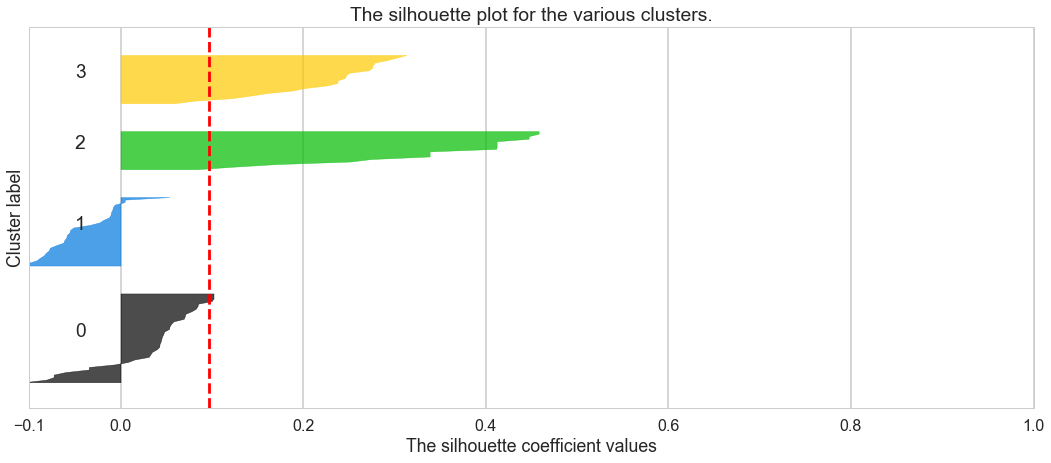

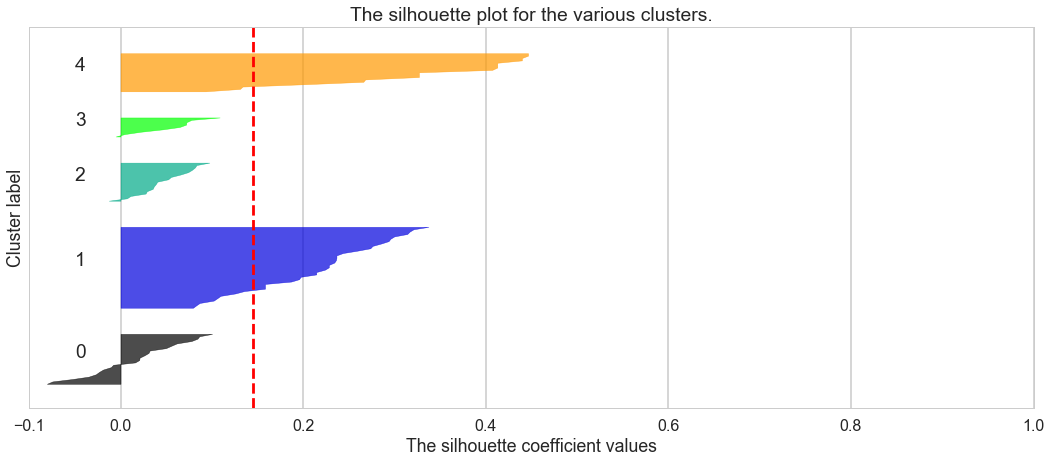

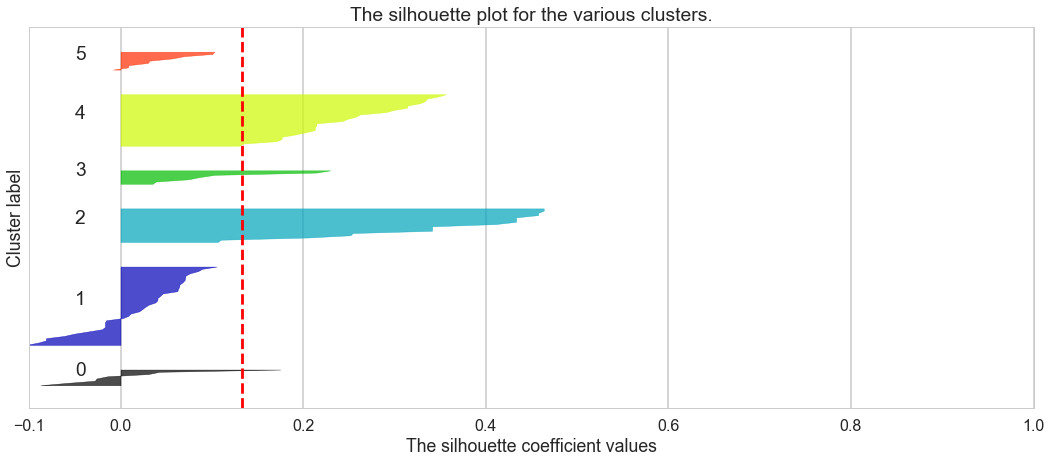

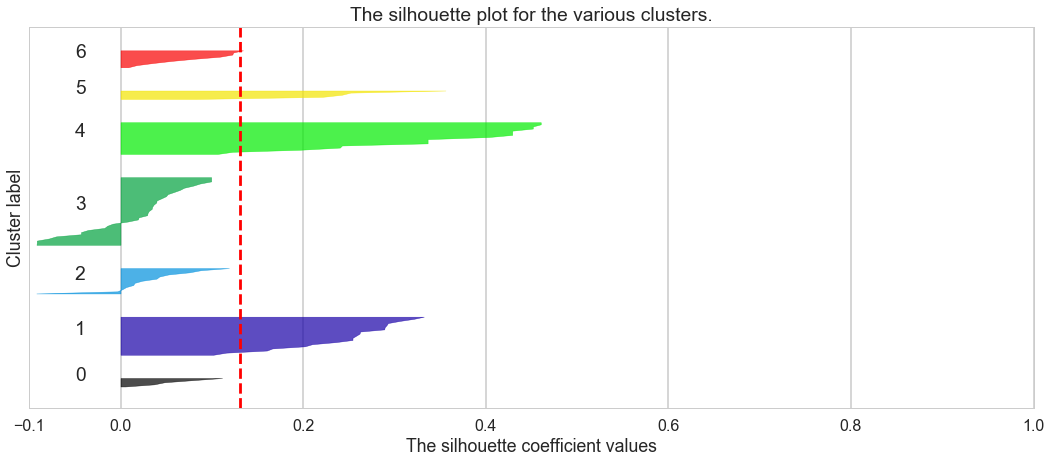

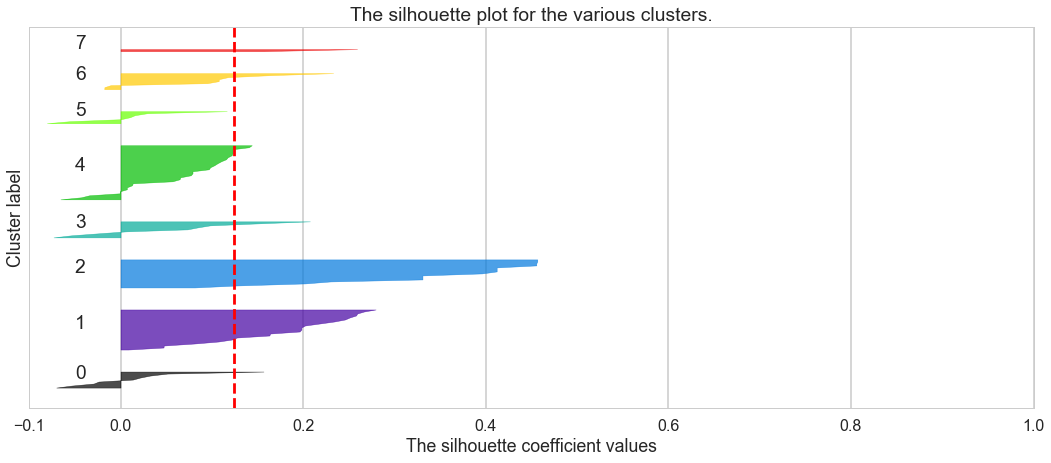

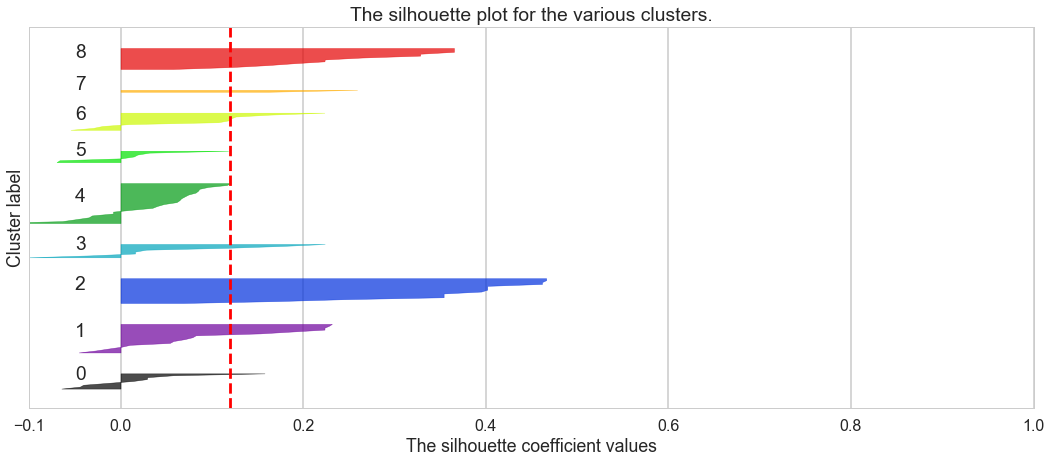

In [87]:
# Your turn.
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.cm as cm

range_n_clusters = range(2,10)
avg_scores = []

for n_clusters in range_n_clusters:
    #Creating a subplot with 1 row and 1 column
    fig, ax1 = plt.subplots(1, 1)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(x_cols) + (n_clusters + 1) * 10])

    #Initializing the clusterer with n_clusters value and a random generator
    #seed of 42 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=42)
    cluster_labels = clusterer.fit_predict(x_cols)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(x_cols, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    #Computing the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(x_cols, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.spectral(float(i) / n_clusters)
        _ = ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        _ = ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    _ = ax1.set_title("The silhouette plot for the various clusters.")
    _ = ax1.set_xlabel("The silhouette coefficient values")
    _ = ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    _ = ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    _ = ax1.set_yticks([])  # Clear the yaxis labels / ticks
    _ = ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

The Silhouette method gives the highest silhouette score for 5 clusters, but the graph shows that it wouldn't be a good choice for our classification, as only 2 clusters have scores above average. From the tested number of clusters, the 8-cluster approach has, probably, the most balanced distribution of silhouette scores, but the average silhouette score for that model is just 0.14. Let's check if the score goes higher for the higher number of clusters:

In [103]:
range_n_clusters_1 = range(10,100)
clust_scores = {}

for n_clusters in range_n_clusters_1:
    clusterer_1 = KMeans(n_clusters=n_clusters, random_state=42)
    cluster_labels_1 = clusterer_1.fit_predict(x_cols)

    silhouette_avg_1 = silhouette_score(x_cols, cluster_labels_1)
    clust_scores[n_clusters] = silhouette_avg_1

print("N of clusters with max score: ", max(clust_scores, key=lambda k: clust_scores[k]))
print("Max score: ", clust_scores.get(max(clust_scores, key=lambda k: clust_scores[k])))

N of clusters with max score:  65
Max score:  0.21961293146


The model shows the highest key for 65 clusters, which seems to be too much (and the score is still not too high). 

### Choosing $K$: The Gap Statistic

There is one last method worth covering for picking $K$, the so-called Gap statistic. The computation for the gap statistic builds on the sum-of-squares established in the Elbow method discussion, and compares it to the sum-of-squares of a "null distribution," that is, a random set of points with no clustering. The estimate for the optimal number of clusters $K$ is the value for which $\log{SS}$ falls the farthest below that of the reference distribution:

$$G_k = E_n^*\{\log SS_k\} - \log SS_k$$

In other words a good clustering yields a much larger difference between the reference distribution and the clustered data. The reference distribution is a Monte Carlo (randomization) procedure that constructs $B$ random distributions of points within the bounding box (limits) of the original data and then applies K-means to this synthetic distribution of data points.. $E_n^*\{\log SS_k\}$ is just the average $SS_k$ over all $B$ replicates. We then compute the standard deviation $\sigma_{SS}$ of the values of $SS_k$ computed from the $B$ replicates of the reference distribution and compute

$$s_k = \sqrt{1+1/B}\sigma_{SS}$$

Finally, we choose $K=k$ such that $G_k \geq G_{k+1} - s_{k+1}$.

### Aside: Choosing $K$ when we Have Labels

Unsupervised learning expects that we do not have the labels. In some situations, we may wish to cluster data that is labeled. Computing the optimal number of clusters is much easier if we have access to labels. There are several methods available. We will not go into the math or details since it is rare to have access to the labels, but we provide the names and references of these measures.

* Adjusted Rand Index
* Mutual Information
* V-Measure
* Fowlkes–Mallows index

See [this article](http://scikit-learn.org/stable/modules/clustering.html) for more information about these metrics.

## Visualizing Clusters using PCA

How do we visualize clusters? If we only had two features, we could likely plot the data as is. But we have 100 data points each containing 32 features (dimensions). Principal Component Analysis (PCA) will help us reduce the dimensionality of our data from 32 to something lower. For a visualization on the coordinate plane, we will use 2 dimensions. In this exercise, we're going to use it to transform our multi-dimensional dataset into a 2 dimensional dataset.

This is only one use of PCA for dimension reduction. We can also use PCA when we want to perform regression but we have a set of highly correlated variables. PCA untangles these correlations into a smaller number of features/predictors all of which are orthogonal (not correlated). PCA is also used to reduce a large set of variables into a much smaller one.

<div class="span5 alert alert-info">
<h3>Checkup Exercise Set IV</h3>

<p><b>Exercise:</b> Use PCA to plot your clusters:</p>

<ul>
<li> Use scikit-learn's [`PCA`](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) function to reduce the dimensionality of your clustering data to 2 components
<li> Create a data frame with the following fields:
  <ul>
  <li> customer name
  <li> cluster id the customer belongs to
  <li> the two PCA components (label them `x` and `y`)
  </ul>
<li> Plot a scatterplot of the `x` vs `y` columns
<li> Color-code points differently based on cluster ID
<li> How do the clusters look? 
<li> Based on what you see, what seems to be the best value for $K$? Moreover, which method of choosing $K$ seems to have produced the optimal result visually?
</ul>

<p><b>Exercise:</b> Now look at both the original raw data about the offers and transactions and look at the fitted clusters. Tell a story about the clusters in context of the original data. For example, do the clusters correspond to wine variants or something else interesting?</p>
</div>

In [135]:
#Initializing the function
from sklearn.decomposition import PCA
pca = PCA(n_components=2)

#Creating the dataframe
df_with_pca = pd.DataFrame(np.array(x_cols.index))

#Initializing clusterer for 3 clusters (from the Elbow method)
clusterer = KMeans(n_clusters=3, random_state=42)

# Continue building dataframe
df_with_pca['cluster'] = pd.DataFrame(clusterer.fit_predict(x_cols)) 
df_with_pca['x'] = pd.DataFrame(pca.fit_transform(x_cols)).iloc[:,0]
df_with_pca['y'] = pd.DataFrame(pca.fit_transform(x_cols)).iloc[:,1]
df_with_pca.columns = ['customer_name', 'cluster', 'x', 'y']
df_with_pca.head()

,customer_name,cluster,x,y
0,Adams,1,1.007580,0.108215
1,Allen,0,-0.287539,0.044715
2,Anderson,2,-0.392032,1.038391
3,Bailey,1,0.699477,-0.022542
4,Baker,0,0.088183,-0.471695


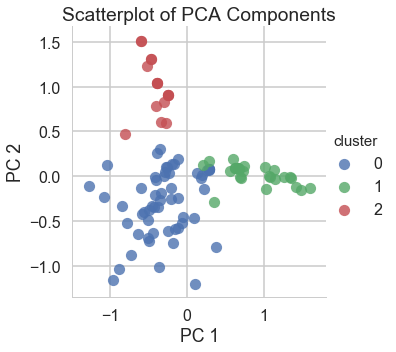

In [132]:
#Plotting a scatterplot
_ = sns.lmplot(data=df_with_pca, x='x', y='y', hue='cluster', fit_reg=False)
_ = plt.xlabel('PC 1')
_ = plt.ylabel('PC 2')
_ = plt.title('Scatterplot of PCA Components')

Based on the scatterplot above, a 3-cluster PCA approach seems to be a good choice--there's a minimal overlap between clusters 0 and 1. To see how the PCA approach behaves with different number of clusters, let's plot a scatterplot for 5 clusters (another potential "elbow" in our analysis above) and for 65 clusters (the number we obtained from the Silhouette method):

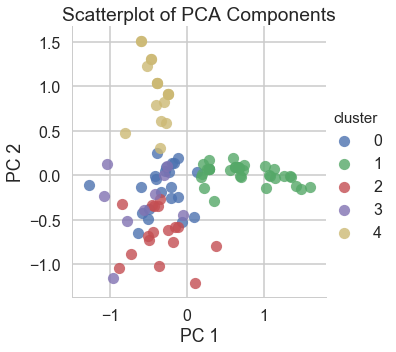

In [136]:
#Creating the dataframe
df_with_pca_5 = pd.DataFrame(np.array(x_cols.index))

#Initializing clusterer for 5 clusters (from the Elbow method)
clusterer_5 = KMeans(n_clusters=5, random_state=42)

# Continue building dataframe
df_with_pca_5['cluster'] = pd.DataFrame(clusterer_5.fit_predict(x_cols)) 
df_with_pca_5['x'] = pd.DataFrame(pca.fit_transform(x_cols)).iloc[:,0]
df_with_pca_5['y'] = pd.DataFrame(pca.fit_transform(x_cols)).iloc[:,1]
df_with_pca_5.columns = ['customer_name', 'cluster', 'x', 'y']

#Plotting a scatterplot
_ = sns.lmplot(data=df_with_pca_5, x='x', y='y', hue='cluster', fit_reg=False)
_ = plt.xlabel('PC 1')
_ = plt.ylabel('PC 2')
_ = plt.title('Scatterplot of PCA Components')

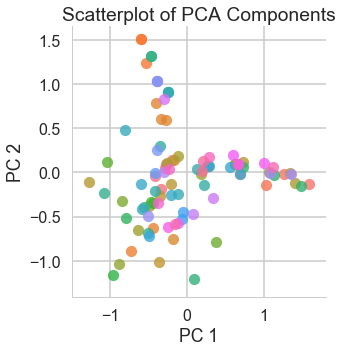

In [137]:
#Creating the dataframe
df_with_pca_65 = pd.DataFrame(np.array(x_cols.index))

#Initializing clusterer for 5 clusters (from the Elbow method)
clusterer_65 = KMeans(n_clusters=65, random_state=42)

# Continue building dataframe
df_with_pca_65['cluster'] = pd.DataFrame(clusterer_65.fit_predict(x_cols)) 
df_with_pca_65['x'] = pd.DataFrame(pca.fit_transform(x_cols)).iloc[:,0]
df_with_pca_65['y'] = pd.DataFrame(pca.fit_transform(x_cols)).iloc[:,1]
df_with_pca_65.columns = ['customer_name', 'cluster', 'x', 'y']

#Plotting a scatterplot
_ = sns.lmplot(data=df_with_pca_65, x='x', y='y', hue='cluster', fit_reg=False, legend=False)
_ = plt.xlabel('PC 1')
_ = plt.ylabel('PC 2')
_ = plt.title('Scatterplot of PCA Components')

Both scatterplots show a poor fit--the clusters are mixed with each other. Hence, the Elbow method with 3 clusters produces the best result so far.

What we've done is we've taken those columns of 0/1 indicator variables, and we've transformed them into a 2-D dataset. We took one column and arbitrarily called it `x` and then called the other `y`. Now we can throw each point into a scatterplot. We color coded each point based on it's cluster so it's easier to see them.

**Exercise: Now look at both the original raw data about the offers and transactions and look at the fitted clusters. Tell a story about the clusters in context of the original data. For example, do the clusters correspond to wine variants or something else interesting?**

In [153]:
#Merging the initial dataframe with the clusters
df_cluster = df_with_pca.loc[:, ['customer_name', 'cluster']]
df_with_clusters = df_merged.merge(df_cluster, on='customer_name')
df_with_clusters.head()

,offer_id,campaign,varietal,min_qty,discount,origin,past_peak,customer_name,n,cluster
0,1,January,Malbec,72,56,France,False,Thomas,1,0
1,4,February,Champagne,72,48,France,True,Thomas,1,0
2,9,April,Chardonnay,144,57,Chile,False,Thomas,1,0
3,11,May,Champagne,72,85,France,False,Thomas,1,0
4,14,June,Merlot,72,64,Chile,False,Thomas,1,0


Let's investigate if the clusters define some meaningful variation. Let's first look at the clustering by wine type:

In [163]:
df_with_clusters.groupby(['cluster']).varietal.value_counts()

cluster  varietal          
0        Champagne             79
         Cabernet Sauvignon    31
         Prosecco              27
         Espumante             15
         Malbec                15
         Chardonnay            14
         Merlot                13
         Pinot Noir             7
         Pinot Grigio           1
1        Espumante             25
         Malbec                16
         Pinot Grigio          16
         Prosecco              14
         Merlot                 6
         Cabernet Sauvignon     1
         Champagne              1
2        Pinot Noir            37
         Prosecco               2
         Champagne              1
         Chardonnay             1
         Malbec                 1
         Merlot                 1
Name: varietal, dtype: int64

Cluster 0 has the largest variety of wines and the largest number of Champagne offers. Cluster 2 is composed mostly of the Pinot Noir offers. Overall, all clusters have both red and white wines and both sparkling and regular wines, so there seems to be no obvious division by the wine type among the clusters. Next, let's look at the country of origin:

In [164]:
df_with_clusters.groupby(['cluster']).origin.value_counts()

cluster  origin      
0        France          88
         Chile           30
         Australia       14
         Oregon          13
         California      12
         Italy           12
         New Zealand     12
         South Africa    12
         Germany          9
1        France          33
         Oregon          13
         Australia       12
         South Africa    12
         Chile            7
         California       2
2        Australia       13
         Italy           12
         France           7
         Germany          7
         California       2
         New Zealand      1
         South Africa     1
Name: origin, dtype: int64

Again, cluster 0 has the largest variety among the countries of origin as well. The wines with the European origin constitute the largest group by region. Let's look at the grouping by the month of campaign:

In [165]:
df_with_clusters.groupby(['cluster']).campaign.value_counts()

cluster  campaign 
0        August       30
         December     27
         March        26
         February     22
         June         19
         May          17
         October      17
         April        15
         January      13
         July          6
         November      6
         September     4
1        March        25
         November     17
         December     16
         July         13
         May           6
         April         1
         August        1
2        October      13
         September    13
         January       7
         July          7
         April         1
         June          1
         May           1
Name: campaign, dtype: int64

March is one of the best months for both group 0 and 1, as well as winter months. For group 2, the most successful season is Autumn. Let's see how the peak/past peak campaigns influence the deals:

In [166]:
df_with_clusters.groupby(['cluster']).past_peak.value_counts()

cluster  past_peak
0        False        158
         True          44
1        False         66
         True          13
2        False         43
Name: past_peak, dtype: int64

As can be seen, all deals in group 2 are not past peak, as well as the majority of the deals in group 0 and 1. Last, let's look at how the minimum quantity and discounts differ by group:

In [168]:
df_with_clusters.groupby(['cluster'])[['min_qty', 'discount']].mean()

,min_qty,discount
cluster,,
0,76.306931,62.391089
1,8.734177,56.050633
2,65.581395,52.116279


The minimum quantity for group 0 is the largest, as well as the discount, so, given the variety of the types of wine, this group probably represents customers who buy relatively large amounts of different wines and get the biggest discounts, which can be representatives of bars, restaurants or similar. The minimum quantity for group 1 is substantially smaller than other 2 groups, while the average discount is second-largest, which means that this group probably represents the buyers of more expensive wines.

<div class="span5 alert alert-info">
<h3>Exercise Set V</h3>

<p>As we saw earlier, PCA has a lot of other uses. Since we wanted to visualize our data in 2 dimensions, restricted the number of dimensions to 2 in PCA. But what is the true optimal number of dimensions?</p>

<p><b>Exercise:</b> Using a new PCA object shown in the next cell, plot the `explained_variance_` field and look for the elbow point, the point where the curve's rate of descent seems to slow sharply. This value is one possible value for the optimal number of dimensions. What is it?</p>
</div>

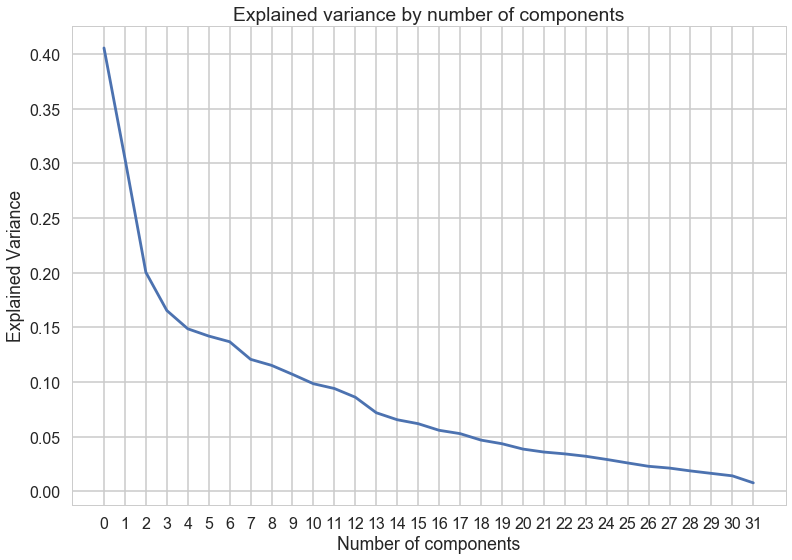

In [177]:
#your turn
# Initialize a new PCA model with a default number of components.
import sklearn.decomposition
pca = sklearn.decomposition.PCA()
pca.fit(x_cols)

#Plotting the explained variance by number of components
_ = plt.plot(pca.explained_variance_)
_ = plt.xlabel('Number of components')
_ = plt.xticks(range(0,32,1))
_ = plt.ylabel('Explained Variance')
_ = plt.title('Explained variance by number of components')

Based on the graph, the optimal number of components can be chosen as 3 or 4, since after those points the explained variance changes much slower.

## Other Clustering Algorithms

k-means is only one of a ton of clustering algorithms. Below is a brief description of several clustering algorithms, and the table provides references to the other clustering algorithms in scikit-learn. 

* **Affinity Propagation** does not require the number of clusters $K$ to be known in advance! AP uses a "message passing" paradigm to cluster points based on their similarity. 

* **Spectral Clustering** uses the eigenvalues of a similarity matrix to reduce the dimensionality of the data before clustering in a lower dimensional space. This is tangentially similar to what we did to visualize k-means clusters using PCA. The number of clusters must be known a priori.

* **Ward's Method** applies to hierarchical clustering. Hierarchical clustering algorithms take a set of data and successively divide the observations into more and more clusters at each layer of the hierarchy. Ward's method is used to determine when two clusters in the hierarchy should be combined into one. It is basically an extension of hierarchical clustering. Hierarchical clustering is *divisive*, that is, all observations are part of the same cluster at first, and at each successive iteration, the clusters are made smaller and smaller. With hierarchical clustering, a hierarchy is constructed, and there is not really the concept of "number of clusters." The number of clusters simply determines how low or how high in the hierarchy we reference and can be determined empirically or by looking at the [dendogram](https://docs.scipy.org/doc/scipy-0.18.1/reference/generated/scipy.cluster.hierarchy.dendrogram.html).

* **Agglomerative Clustering** is similar to hierarchical clustering but but is not divisive, it is *agglomerative*. That is, every observation is placed into its own cluster and at each iteration or level or the hierarchy, observations are merged into fewer and fewer clusters until convergence. Similar to hierarchical clustering, the constructed hierarchy contains all possible numbers of clusters and it is up to the analyst to pick the number by reviewing statistics or the dendogram.

* **DBSCAN** is based on point density rather than distance. It groups together points with many nearby neighbors. DBSCAN is one of the most cited algorithms in the literature. It does not require knowing the number of clusters a priori, but does require specifying the neighborhood size.

### Clustering Algorithms in Scikit-learn
<table border="1">
<colgroup>
<col width="15%" />
<col width="16%" />
<col width="20%" />
<col width="27%" />
<col width="22%" />
</colgroup>
<thead valign="bottom">
<tr><th>Method name</th>
<th>Parameters</th>
<th>Scalability</th>
<th>Use Case</th>
<th>Geometry (metric used)</th>
</tr>
</thead>
<tbody valign="top">
<tr><td>K-Means</span></a></td>
<td>number of clusters</td>
<td>Very large<span class="pre">n_samples</span>, medium <span class="pre">n_clusters</span> with
MiniBatch code</td>
<td>General-purpose, even cluster size, flat geometry, not too many clusters</td>
<td>Distances between points</td>
</tr>
<tr><td>Affinity propagation</td>
<td>damping, sample preference</td>
<td>Not scalable with n_samples</td>
<td>Many clusters, uneven cluster size, non-flat geometry</td>
<td>Graph distance (e.g. nearest-neighbor graph)</td>
</tr>
<tr><td>Mean-shift</td>
<td>bandwidth</td>
<td>Not scalable with <span class="pre">n_samples</span></td>
<td>Many clusters, uneven cluster size, non-flat geometry</td>
<td>Distances between points</td>
</tr>
<tr><td>Spectral clustering</td>
<td>number of clusters</td>
<td>Medium <span class="pre">n_samples</span>, small <span class="pre">n_clusters</span></td>
<td>Few clusters, even cluster size, non-flat geometry</td>
<td>Graph distance (e.g. nearest-neighbor graph)</td>
</tr>
<tr><td>Ward hierarchical clustering</td>
<td>number of clusters</td>
<td>Large <span class="pre">n_samples</span> and <span class="pre">n_clusters</span></td>
<td>Many clusters, possibly connectivity constraints</td>
<td>Distances between points</td>
</tr>
<tr><td>Agglomerative clustering</td>
<td>number of clusters, linkage type, distance</td>
<td>Large <span class="pre">n_samples</span> and <span class="pre">n_clusters</span></td>
<td>Many clusters, possibly connectivity constraints, non Euclidean
distances</td>
<td>Any pairwise distance</td>
</tr>
<tr><td>DBSCAN</td>
<td>neighborhood size</td>
<td>Very large <span class="pre">n_samples</span>, medium <span class="pre">n_clusters</span></td>
<td>Non-flat geometry, uneven cluster sizes</td>
<td>Distances between nearest points</td>
</tr>
<tr><td>Gaussian mixtures</td>
<td>many</td>
<td>Not scalable</td>
<td>Flat geometry, good for density estimation</td>
<td>Mahalanobis distances to  centers</td>
</tr>
<tr><td>Birch</td>
<td>branching factor, threshold, optional global clusterer.</td>
<td>Large <span class="pre">n_clusters</span> and <span class="pre">n_samples</span></td>
<td>Large dataset, outlier removal, data reduction.</td>
<td>Euclidean distance between points</td>
</tr>
</tbody>
</table>
Source: http://scikit-learn.org/stable/modules/clustering.html

<div class="span5 alert alert-info">
<h3>Exercise Set VI</h3>

<p><b>Exercise:</b> Try clustering using the following algorithms. </p>
<ol>
<li>Affinity propagation
<li>Spectral clustering
<li>Agglomerative clustering
<li>DBSCAN
</ol>
<p>How do their results compare? Which performs the best? Tell a story why you think it performs the best.</p>
</div>


#### Affinity propagation clustering

In [181]:
#Importing the package
from sklearn.cluster import AffinityPropagation

#Finding the best value for damping parameter (between 0.5 and 0.9, can't be 1) 
damping_parameter = [0.5, 0.6, 0.7, 0.8, 0.9]
best_score = 0.0
for parameter in damping_parameter:
    ap = AffinityPropagation(damping=parameter)
    labels = ap.fit_predict(x_cols)
    silhouette_avg_score = silhouette_score(x_cols, labels, random_state=42)
    print("Damping = ", parameter,
          "Average silhouette_score = ", silhouette_avg_score)
    if silhouette_avg_score > best_score:
        best_score = silhouette_avg_score
        best_damping_parameter = parameter
        
print('Best damping parameter: ', best_damping_parameter)
print('Best silhouette score: ', best_score)

Damping =  0.5 Average silhouette_score =  0.123465236045
Damping =  0.6 Average silhouette_score =  0.123465236045
Damping =  0.7 Average silhouette_score =  0.123465236045
Damping =  0.8 Average silhouette_score =  0.0895455499989
Damping =  0.9 Average silhouette_score =  0.0895455499989
Best damping parameter:  0.5
Best silhouette score:  0.123465236045


#### Spectral Clustering

In [183]:
#Importing packages
from sklearn.cluster import SpectralClustering

#Finding the best value for n_clusters parameter
clusters_range = range(2,11)
best_score = 0.0
for n in clusters_range:
    sc = SpectralClustering(n_clusters=n)
    labels = sc.fit_predict(x_cols)
    silhouette_avg = silhouette_score(x_cols, labels, random_state=42)
    print("n_clusters = ", n,
          "Average silhouette_score = ", silhouette_avg)
    if silhouette_avg > best_score:
        best_score = silhouette_avg
        best_n_clusters = n
        
print('Best n_clusters parameter = ',best_n_clusters)
print('Best silhouette score: ', best_score)

n_clusters =  2 Average silhouette_score =  0.0591405970172
n_clusters =  3 Average silhouette_score =  0.0999059123102
n_clusters =  4 Average silhouette_score =  0.0290656989328
n_clusters =  5 Average silhouette_score =  0.0264024437703
n_clusters =  6 Average silhouette_score =  0.0175964169953
n_clusters =  7 Average silhouette_score =  0.0526931828711
n_clusters =  8 Average silhouette_score =  0.0440363219911
n_clusters =  9 Average silhouette_score =  0.0451897166321
n_clusters =  10 Average silhouette_score =  0.0645169789642
Best n_clusters parameter =  3
Best silhouette score:  0.0999059123102


#### Agglomerative clustering

In [185]:
#Importing packages
from sklearn.cluster import AgglomerativeClustering

#Finding the best value for n_clusters parameter
clusters_range = range(2,11)
best_score = 0.0
for n in clusters_range:
    ac = AgglomerativeClustering(n_clusters=n)
    labels = ac.fit_predict(x_cols)
    silhouette_avg = silhouette_score(x_cols, labels, random_state=42)
    print("n_clusters = ", n,
          "Average silhouette_score = ", silhouette_avg)
    if silhouette_avg > best_score:
        best_score = silhouette_avg
        best_n_clusters = n
        
print('Best n_clusters parameter = ',best_n_clusters)
print('Best silhouette score: ', best_score)

n_clusters =  2 Average silhouette_score =  0.0825801782318
n_clusters =  3 Average silhouette_score =  0.116258788636
n_clusters =  4 Average silhouette_score =  0.128937578159
n_clusters =  5 Average silhouette_score =  0.140897399708
n_clusters =  6 Average silhouette_score =  0.147152172046
n_clusters =  7 Average silhouette_score =  0.152751527511
n_clusters =  8 Average silhouette_score =  0.155780537186
n_clusters =  9 Average silhouette_score =  0.12075124132
n_clusters =  10 Average silhouette_score =  0.0975475074715
Best n_clusters parameter =  8
Best silhouette score:  0.155780537186


#### DBSCAN

In [187]:
#Importing packages
from sklearn.cluster import DBSCAN

#Finding the best value for n_clusters parameter
min_samples_range = [1, 2, 3]
best_score = 0.0
for min_sample in min_samples_range:
    db = DBSCAN(min_samples=min_sample)
    labels = db.fit_predict(x_cols)
    silhouette_avg = silhouette_score(x_cols, labels, random_state=42)
    print("min_samples = ", min_sample,
          "Average silhouette_score = ", silhouette_avg)
    if silhouette_avg > best_score:
        best_score = silhouette_avg
        best_n_clusters = min_sample
        
print('Best min_samples parameter = ',best_n_clusters)
print('Best silhouette score: ', best_score)

min_samples =  1 Average silhouette_score =  0.19
min_samples =  2 Average silhouette_score =  -0.0216780594814
min_samples =  3 Average silhouette_score =  -0.106635558255
Best min_samples parameter =  1
Best silhouette score:  0.19


All clustering models don't produce a high silhouette score. DBSCAN produced the best score, but it's parameter for the best score is not very helpful, as it would allow to create clusters with only one sample.